# Preliminary Experiments to Analyse Task Decompositions in MoE Model for CIFAR-100 Dataset

In this notebook we run experiments, as detailed in the figure below, to analyse task decomposition in MoE models and if there is a training or error advantage for bad decompositions.

![](../figures/exp_flow.png)

In [30]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [31]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [33]:
# !pip3 install continuum

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [35]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. They are in the folder \\$root/models/pre_trained . You can either copy them to the \\$root/models folder or load them directly from the pre_trained folder (just make sure you use the correct folder).

## Load CIFAR-100 dataset

In [36]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)        

In [37]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [38]:
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
cifar100_testset, cifar100_trainset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                ToTensor()
                Normalize(mean=(0.5074, 0.4867, 0.4411), std=(0.2011, 0.1987, 0.2025))
            ))

In [39]:
num_classes = 100

In [40]:
trainsize = 50000
testsize = 10000

In [41]:
batch_size = 256

In [42]:
cifar100_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)
cifar100_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar100_testset, range(testsize)), batch_size=batch_size,
                                         shuffle=True, num_workers=4, pin_memory=True)

In [43]:
import csv
with open('data/cifar100_class_names.txt','r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    classes_cifar100 = []
    for row in csvreader:
        if row:
            classes_cifar100.append(row[1])

classes_cifar100            

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [44]:
from collections import OrderedDict

coarse_labels_str = OrderedDict({'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers':['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers':['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables':['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical devices':['clock', 'keyboard', 'lamp', 'telephone', 'television'],
'household furniture':['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects':['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores':['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things':['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes':['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores':['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals':['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates':['crab', 'lobster', 'snail', 'spider', 'worm'],
'people':['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles':['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals':['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees':['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1':['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2':['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']})

In [45]:
coarse_labels = []
for coarse, fine in coarse_labels_str.items():
    labels = []
    for label in fine:
        labels.append(classes_cifar100.index(label))
    coarse_labels.append(labels)
coarse_labels

[[4, 30, 55, 72, 95],
 [1, 32, 67, 73, 91],
 [54, 62, 70, 82, 92],
 [9, 10, 16, 28, 61],
 [0, 51, 53, 57, 83],
 [22, 39, 40, 86, 87],
 [5, 20, 25, 84, 94],
 [6, 7, 14, 18, 24],
 [3, 42, 43, 88, 97],
 [12, 17, 37, 68, 76],
 [23, 33, 49, 60, 71],
 [15, 19, 21, 31, 38],
 [34, 63, 64, 66, 75],
 [26, 45, 77, 79, 99],
 [2, 11, 35, 46, 98],
 [27, 29, 44, 78, 93],
 [36, 50, 65, 74, 80],
 [47, 52, 56, 59, 96],
 [8, 13, 48, 58, 90],
 [41, 69, 81, 85, 89]]

In [46]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18), filename='cifar100_images'):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=False, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    count = 0
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = np.clip(img.numpy(),0,1)
        ax[i].imshow(npimg) 
        ax[i].axis('off')  
        # if titles is not None and i<10:
        ax[i].set_title(titles[count])
        count+=1
    plt.savefig(filename)
    plt.show()

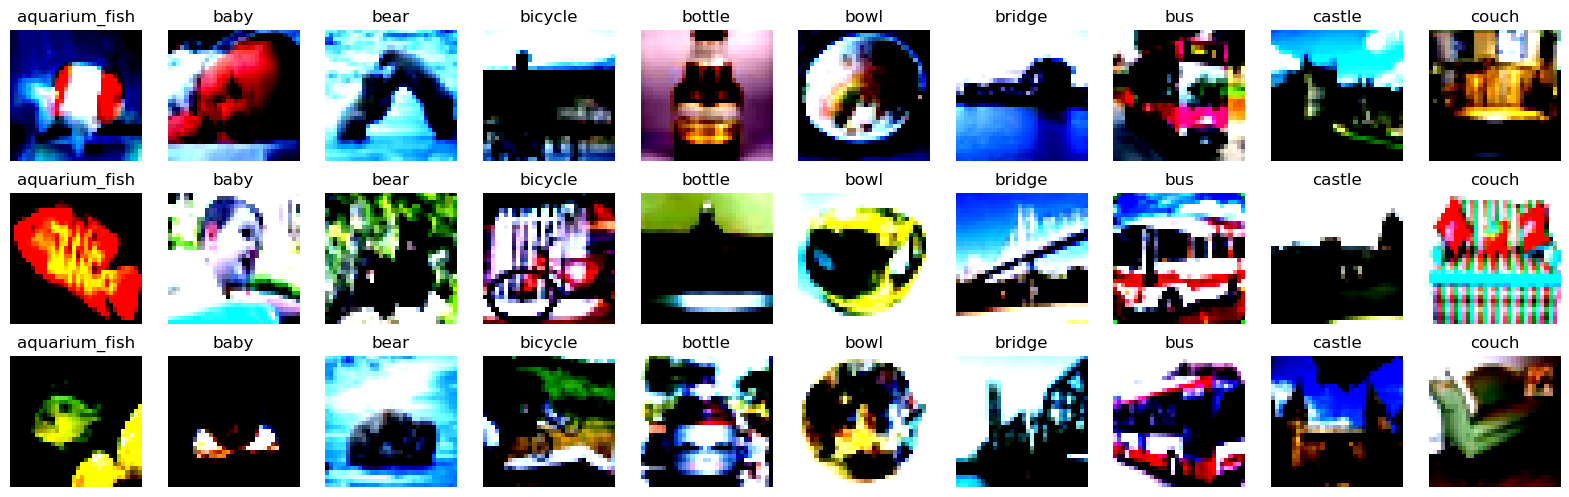

In [47]:
# get some random training images
dataiter = iter(cifar100_testloader)
images, labels = dataiter.next()

images_to_plot = []
count = 0
selected_labels = [0]*30
for i in range(100):
    if count == 10:
        break
    index = np.where(labels==i)[0]
    if len(index) >= 3:
        selected_labels[count] = i
        selected_labels[count+10] = i
        selected_labels[count+20] = i
        images_to_plot.append(images[index[0:3],:,:])
        count += 1
    
selected_labels = [classes_cifar100[i] for i in selected_labels]
images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
new_shape = images_to_plot.shape
images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
images_to_plot = images_to_plot.permute(0,2,3,1)
plot_colour_images(images_to_plot, nrows=3, ncols=10,thefigsize=(20,6), titles=selected_labels)

## Define expert and gate networks

In [48]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=3):
        super(expert_layers, self).__init__()
        filter_size = 3
        self.filters = 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2,512)
        self.fc2 = nn.Linear(512, 128)
        
        self.out = nn.Linear(in_features=128, out_features=num_classes)
                        
    def forward(self, x):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))    
    
        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*8*2*2)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        self.hidden = x
        
        x = F.relu(x)
        
        x = self.out(x)
        
        # output
        x = F.softmax(x, dim=1)

        return x

In [49]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*8, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(self.filters*8)

        self.fc1 = nn.Linear(self.filters*8*2*2, 512)
        self.fc2 = nn.Linear(512, 128)
        
        self.out = nn.Linear(in_features=128, out_features=num_experts)
        
    def forward(self, x, T=1.0, y=None):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn8(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*8*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        x = F.softmax(x/T, dim=1)
        return x


In [50]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers, channels=1):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes, channels))
    return nn.ModuleList(models)

In [51]:
from helper import moe_models
from moe_models.moe_models_base import moe_models_base

# The moe architecture that outputs an expected output of the experts
# based on the gate probabilities
class moe_best_expert_model(moe_models_base):

    def __init__(self, num_experts=5, num_classes=10, augment=0, attention_flag=0, hidden=None, experts=None, gate=None, task='classification',device = torch.device("cpu")):
        super(moe_expectation_model,self).__init__(num_experts, num_classes, augment, attention_flag, hidden, experts, gate, task, device)
        self.device = device

    def forward(self,inputs, T=1.0):

        p = self.gate(inputs, T)

        self.gate_outputs = p
        
        selected_experts = torch.argmax(p, dim=1)
    
        for i, expert in enumerate(self.experts):
            expert_output = expert(inputs)
            y.append(expert_output.view(1,-1,self.num_classes))
            
        y = torch.vstack(y).transpose_(0,1).to(self.device)

        self.expert_outputs = y
        
        output = y[:,selected_experts,:]

        return output


## Initialize configurations and helper functions

In [52]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [53]:
# Generate the string reprensentation of the class split used for pre-training the experts
def classes_per_expert_str(classes_per_expert):
    buffer_str = ''
    for labels in classes_per_expert:
        buffer = "_".join(str(labels).replace('[','').replace(']','').replace(',','_').replace(" ",'')).replace('_','')
        buffer_str += buffer+'_'
    buffer_str = buffer_str.strip('_')
    return buffer_str

## Experiments

### Experiment 1: Train MoE expectation model with un-trained experts

#### The MoE model is first trained with un-trained experts. The gate trained in this model is then used to train a new model with new experts with (a) default parameters and (b) parameters initialized to parameters of the experts that the gate was trained with. 

#### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar100_scratch'
# Model with gate parameters fixed to learnt gate parameters from model_1 and experts initialized to 
# the same initial parameters as experts from model_1 before they were trained
model_2 = 'cifar100_pretrained_gate_scratch_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_1 and experts initialized to 
# default parameters
model_3 = 'cifar100_pretrained_gate_scratch_rand_wts'

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 40

In [ ]:
T = [1.0]*num_epochs

In [ ]:
# Train models model_1, model_2 and model_3 for 10 runs
n_runs = 5
n_run_models_1 = []
n_run_models_2 = []
n_run_models_3 = []

for n_run in range(1, n_runs+1):
    print('RUN', n_run)
    
    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }
    
    models_gate_pretrained_same_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    saved_experts = {}
        
    # Build model with un-trained experts
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with un-trained experts')
        # copy and save the expert models to save the parameters
        expert_models_copy = experts(total_experts, num_classes).to(device)

        # copy and save the expert models to save the parameters
        expert_models = deepcopy(expert_models_copy)
        saved_experts[key] = expert_models_copy
        
        gate_model = gate_layers(total_experts).to(device)

        moe_model = val['model'](total_experts, num_classes, 
                                 experts=expert_models, gate=gate_model, device=device)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        # optimizer_moe = optim.RMSprop(moe_model.parameters(),
        #                           lr=0.001, momentum=0.9)
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    # Save all the trained models
    plot_file = generate_plot_file(model_1, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
    n_run_models_1.append(models)
    torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_run_models_1 = []
    
        # train new experts with pre-trained gate fom model_1 above with same parameters as the 
    # experts it was trained from
    for key, val in models_gate_pretrained_same_wts.items():
        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')
        
        # copy parameters of the experts
        expert_models = deepcopy(saved_experts[key])

        # load the pre-trained gate model
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the parameters of the gate
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model, device=device)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    # Save all the trained models
    plot_file = generate_plot_file(model_2, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_run_models_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
    n_run_models_2.append(models_gate_pretrained_same_wts)
    torch.save(n_run_models_2,open(os.path.join(model_path, plot_file),'wb'))
    n_run_models_2 = []


    # Train new experts with pre-trained gate fom model_1 above with default parameters
    for key, val in models_gate_pretrained_rand_wts.items():
        
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts, num_classes).to(device)

        # load pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model, device=device)

        optimizer_moe = optim.RMSprop(moe_model.parameters(),
                                  lr=0.001, momentum=0.9)
        
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    
    # Save all the trained models
    plot_file = generate_plot_file(model_3, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_run_models_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
    n_run_models_3.append(models_gate_pretrained_rand_wts)
    torch.save(n_run_models_3,open(os.path.join(model_path, plot_file),'wb'))
    n_run_models_3 = []



### Experiment 2: Train MoE expectation model with pre-trained experts

#### The MoE model is first trained with pre-trained experts trained on pre-defined data splits. The gate trained in this model is then used to train a new model with new experts with (a) default parameters and (b) parameters initialized to parameters of the experts that the gate was trained with. 

#### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

#### Train with pre-defined data split by coarse labels

In [58]:
# This is the split used in the paper
classes_per_expert_list = [coarse_labels]
classes_per_expert_list 

[[[4, 30, 55, 72, 95],
  [1, 32, 67, 73, 91],
  [54, 62, 70, 82, 92],
  [9, 10, 16, 28, 61],
  [0, 51, 53, 57, 83],
  [22, 39, 40, 86, 87],
  [5, 20, 25, 84, 94],
  [6, 7, 14, 18, 24],
  [3, 42, 43, 88, 97],
  [12, 17, 37, 68, 76],
  [23, 33, 49, 60, 71],
  [15, 19, 21, 31, 38],
  [34, 63, 64, 66, 75],
  [26, 45, 77, 79, 99],
  [2, 11, 35, 46, 98],
  [27, 29, 44, 78, 93],
  [36, 50, 65, 74, 80],
  [47, 52, 56, 59, 96],
  [8, 13, 48, 58, 90],
  [41, 69, 81, 85, 89]]]

In [ ]:
# Function to pre-train experts according to the split
def train_experts(masks, total_experts, num_classes, num_epochs, batch_size,
                  trainset, testset):
    expert_models_copy = experts(total_experts, num_classes).to(device)
    expert_models = deepcopy(expert_models_copy)
    
    for mask, expert in zip(masks, expert_models):
        print('Classes', mask)
        indices = []
        for m in mask:
            indices += torch.where(torch.tensor(trainset.targets[0:trainsize]) == m)[0]
        
        trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(torch.utils.data.Subset(trainset, range(0, trainsize)), indices), 
                                          batch_size=batch_size,
                                          shuffle=True)
        
        optimizer_expert = optim.Adam(expert.parameters(), lr=0.001, amsgrad=False)

        loss_criterion = cross_entropy_loss()
        for epoch in range(num_epochs):
            running_loss = 0.0
            train_running_accuracy = 0.0
            num_batches = 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = expert(inputs)

                optimizer_expert.zero_grad()
                loss = loss_criterion(outputs, None, None,labels)

                loss.backward()

                optimizer_expert.step()

                running_loss += loss.item()

                outputs = expert(inputs)

                acc = accuracy(outputs, labels)
                train_running_accuracy += acc

                num_batches += 1
                
            print('epoch %d' % epoch,
                  'training loss %.2f' % (running_loss/num_batches),
                   ', training accuracy %.2f' % (train_running_accuracy/num_batches),
                   )
    pre_trained_expert = 'cifar100_pre_trained'
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_expert_model.pt')
    print(plot_file)
    torch.save([expert_models, expert_models_copy],open(os.path.join(model_path, plot_file),'wb'))
    return expert_models, expert_models_copy

In [ ]:
total_experts = 20

In [ ]:
num_epochs = 100

In [ ]:
# Pre-train experts on pre-defined splits
for class_per_expert in classes_per_expert_list:
    # print(class_per_expert)
    expert_models, expert_models_copy = train_experts(masks=class_per_expert, total_experts=total_experts, 
                                                      num_classes=num_classes, num_epochs=num_epochs, batch_size=batch_size,
                                                      trainset=cifar100_trainset,testset=cifar100_testset)

#### NOTE: We have provided expert models already pre-trained with the above class splits

#### Train with pre-trained experts and moe_expectation_model 

In [94]:
# Model trained with pre-trained experts
model_4 = 'cifar100_pretrained_gate_prechosen'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to 
# the same initial parameters as experts from model_4 before they were trained
model_5 = 'cifar100_pretrained_gate_prechosen_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to default parameters
model_6 = 'cifar100_pretrained_gate_prechosen_rand_wts'

In [95]:
total_experts = 20

In [96]:
num_epochs = 40

In [97]:
pre_trained_expert = 'cifar100_pre_trained'

In [98]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
T = [1.0]*num_epochs
#re_trained_expert = 'mnist_pre_trained_10K'
n_split_models_1 = []
n_split_models_2 = []
n_split_models_3 = []

for classes_per_expert in classes_per_expert_list:
    print(classes_per_expert)
    
    n_split_models = []

    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    models_gate_pretrained_same_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    # Load the pre-trained experts for the corresponding split
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_expert_model.pt')
    print(plot_file)
    expert_models, expert_models_copy = torch.load(os.path.join(model_path, plot_file), map_location=device)

    for i, expert in enumerate(expert_models):
        for param in expert.parameters():
            param.requires_grad = False
            
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = expert_models.to(device)

        gate_model = gate_layers(total_experts)

        moe_model = val['model'](total_experts, num_classes, 
                                 experts=expert_models, gate=gate_model, device=device)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_4, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_1.append(models)
    torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_1 = []
    
    for key, val in models_gate_pretrained_same_wts.items():

        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')

        # copy parameters of the experts
        expert_models = expert_models_copy

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model, device=device)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_5, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_2.append(models_gate_pretrained_same_wts)
    torch.save(n_split_models_2,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_2 = []


    for key, val in models_gate_pretrained_rand_wts.items():
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts, num_classes).to(device)

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model, device=device)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    
    plot_file = generate_plot_file(model_6, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_3.append(models_gate_pretrained_rand_wts)
    torch.save(n_split_models_3,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_3 = []
    

[[4, 30, 55, 72, 95], [1, 32, 67, 73, 91], [54, 62, 70, 82, 92], [9, 10, 16, 28, 61], [0, 51, 53, 57, 83], [22, 39, 40, 86, 87], [5, 20, 25, 84, 94], [6, 7, 14, 18, 24], [3, 42, 43, 88, 97], [12, 17, 37, 68, 76], [23, 33, 49, 60, 71], [15, 19, 21, 31, 38], [34, 63, 64, 66, 75], [26, 45, 77, 79, 99], [2, 11, 35, 46, 98], [27, 29, 44, 78, 93], [36, 50, 65, 74, 80], [47, 52, 56, 59, 96], [8, 13, 48, 58, 90], [41, 69, 81, 85, 89]]
cifar100_pre_trained_100_20_expert_model.pt
Model: moe_expectation_model 20 Experts
Building model with pre-trained experts
model params: 2668948
epoch 0 training loss 2.66 , training accuracy 0.29 , test accuracy 0.28
epoch 1 training loss 2.19 , training accuracy 0.42 , test accuracy 0.36
epoch 2 training loss 1.95 , training accuracy 0.48 , test accuracy 0.40
epoch 3 training loss 1.80 , training accuracy 0.52 , test accuracy 0.42
epoch 4 training loss 1.70 , training accuracy 0.55 , test accuracy 0.45
epoch 5 training loss 1.59 , training accuracy 0.58 , test

#### Train with pre-trained experts and moe_best_expert_model 

In [39]:
# Model trained with pre-trained experts
model_4 = 'cifar100_pretrained_gate_prechosen_best'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to 
# the same initial parameters as experts from model_4 before they were trained
model_5 = 'cifar100_pretrained_gate_prechosen_best_same_wts'
# Model with gate parameters fixed to learnt gate parameters from model_4 and experts initialized to default parameters
model_6 = 'cifar100_pretrained_gate_prechosen_best_rand_wts'

In [40]:
total_experts = 20

In [41]:
num_epochs = 40

In [42]:
pre_trained_expert = 'cifar100_pre_trained'

In [43]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
T = [1.0]*num_epochs
#re_trained_expert = 'mnist_pre_trained_10K'
n_split_models_1 = []
n_split_models_2 = []
n_split_models_3 = []

for classes_per_expert in classes_per_expert_list:
    print(classes_per_expert)
    
    n_split_models = []

    models = {
        'moe_best_expert_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    models_gate_pretrained_same_wts = {
        'moe_best_expert_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    models_gate_pretrained_rand_wts = {
        'moe_best_expert_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    # Load the pre-trained experts for the corresponding split
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_expert_model.pt')
    print(plot_file)
    expert_models, expert_models_copy = torch.load(os.path.join(model_path, plot_file), map_location=device)

    for i, expert in enumerate(expert_models):
        for param in expert.parameters():
            param.requires_grad = False
            
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = expert_models.to(device)

        gate_model = gate_layers(total_experts)

        moe_model = val['model'](total_experts, num_classes, 
                                 experts=expert_models, gate=gate_model, device=device)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_4, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_1.append(models)
    torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_1 = []
    
    for key, val in models_gate_pretrained_same_wts.items():

        print('Building model with pre-trained gate and new experts initialized to same parameters as experts used to train the gate')

        # copy parameters of the experts
        expert_models = expert_models_copy

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model, device=device)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T, 
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_5, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_2.append(models_gate_pretrained_same_wts)
    torch.save(n_split_models_2,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_2 = []


    for key, val in models_gate_pretrained_rand_wts.items():
        print('Building model with pre-trained gate and new experts initialized to default parameters')

        # initialize the expert parameters to default parameters
        expert_models = experts(total_experts, num_classes).to(device)

        # load the pre-trained gate
        gate_model = models[key]['experts'][total_experts]['model'].gate

        # Fix the gate parameters
        for param in gate_model.parameters():
            param.requires_grad = False

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0, 
                                 experts=expert_models, gate=gate_model, device=device)

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
        
        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}
    
    plot_file = generate_plot_file(model_6, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_3.append(models_gate_pretrained_rand_wts)
    torch.save(n_split_models_3,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_3 = []
    

[[4, 30, 55, 72, 95], [1, 32, 67, 73, 91], [54, 62, 70, 82, 92], [9, 10, 16, 28, 61], [0, 51, 53, 57, 83], [22, 39, 40, 86, 87], [5, 20, 25, 84, 94], [6, 7, 14, 18, 24], [3, 42, 43, 88, 97], [12, 17, 37, 68, 76], [23, 33, 49, 60, 71], [15, 19, 21, 31, 38], [34, 63, 64, 66, 75], [26, 45, 77, 79, 99], [2, 11, 35, 46, 98], [27, 29, 44, 78, 93], [36, 50, 65, 74, 80], [47, 52, 56, 59, 96], [8, 13, 48, 58, 90], [41, 69, 81, 85, 89]]
cifar100_pre_trained_100_20_expert_model.pt
Model: moe_best_expert_model 20 Experts
Building model with pre-trained experts
model params: 2668948
epoch 0 training loss 2.65 , training accuracy 0.29 , test accuracy 0.30
epoch 1 training loss 2.19 , training accuracy 0.41 , test accuracy 0.36
epoch 2 training loss 1.97 , training accuracy 0.47 , test accuracy 0.38
epoch 3 training loss 1.82 , training accuracy 0.52 , test accuracy 0.43
epoch 4 training loss 1.71 , training accuracy 0.55 , test accuracy 0.44
epoch 5 training loss 1.61 , training accuracy 0.57 , test

#### Train with pre-trained experts without fixing expert weights and moe_expectation_model 

In [60]:
# This is the split used in the paper
classes_per_expert_list = [coarse_labels]

In [61]:
# Model trained with pre-trained experts
model_4 = 'cifar100_pretrained_gate_prechosen_unfixed'

In [62]:
total_experts = 20

In [63]:
num_epochs = 40

In [64]:
pre_trained_expert = 'cifar100_pre_trained'

In [65]:
# Train models model_4, model_5 and model_6 for the different splits of the digits shown above.
T = [1.0]*num_epochs
n_split_models_1 = []

for classes_per_expert in classes_per_expert_list:
    print(classes_per_expert)
    
    n_split_models = []

    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss().to(device),'experts':{}},
        }

    # Load the pre-trained experts for the corresponding split
    plot_file = generate_plot_file(pre_trained_expert, specific=str(num_classes)+'_'+str(total_experts)+'_expert_model.pt')
    print(plot_file)
    expert_models, _ = torch.load(os.path.join(model_path, plot_file), map_location=device)
            
    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        print('Building model with pre-trained experts')

        expert_models = expert_models.to(device)

        gate_model = gate_layers(total_experts)

        moe_model = val['model'](total_experts, num_classes, 
                                 experts=expert_models, gate=gate_model, device=device)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

        hist = moe_model.train(cifar100_trainloader, cifar100_testloader,  val['loss'], optimizer_moe, T=T,
                               accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_4, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    if os.path.exists(os.path.join(model_path, plot_file)):
        n_split_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))

    n_split_models_1.append(models)
    torch.save(n_split_models_1,open(os.path.join(model_path, plot_file),'wb'))
    n_split_models_1 = []
    


[[4, 30, 55, 72, 95], [1, 32, 67, 73, 91], [54, 62, 70, 82, 92], [9, 10, 16, 28, 61], [0, 51, 53, 57, 83], [22, 39, 40, 86, 87], [5, 20, 25, 84, 94], [6, 7, 14, 18, 24], [3, 42, 43, 88, 97], [12, 17, 37, 68, 76], [23, 33, 49, 60, 71], [15, 19, 21, 31, 38], [34, 63, 64, 66, 75], [26, 45, 77, 79, 99], [2, 11, 35, 46, 98], [27, 29, 44, 78, 93], [36, 50, 65, 74, 80], [47, 52, 56, 59, 96], [8, 13, 48, 58, 90], [41, 69, 81, 85, 89]]
cifar100_pre_trained_100_20_expert_model.pt
Model: moe_expectation_model 20 Experts
Building model with pre-trained experts
model params: 11445348
epoch 0 training loss 2.89 , training accuracy 0.30 , test accuracy 0.31
epoch 1 training loss 2.38 , training accuracy 0.43 , test accuracy 0.36
epoch 2 training loss 2.18 , training accuracy 0.48 , test accuracy 0.42
epoch 3 training loss 2.00 , training accuracy 0.53 , test accuracy 0.43
epoch 4 training loss 1.88 , training accuracy 0.55 , test accuracy 0.45
epoch 5 training loss 1.79 , training accuracy 0.58 , tes

### Jump to [Results](#Results) if you just want to run pre-trained models and see the results

In [69]:
total_experts = 5

In [70]:
num_epochs = 20

In [71]:
model_7 = 'mnist_with_reg'

In [ ]:
# Train the MoE model with gate coefficient of variation regularization

# Enable regularization
w_importance = 1.0

print('w_importance', w_importance)
models = {
    'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
    }

for key, val in models.items():
    print('Model:', key, total_experts, 'Experts')
    expert_models = experts(total_experts, [None]*total_experts, num_classes, 
                            [num_classes]*total_experts).to(device)

    gate_model = gate_layers(total_experts, num_classes).to(device)

    moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                             experts=expert_models, gate=gate_model)

    params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
    print('model params:', sum(params))

    optimizer_moe = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                           w_importance=w_importance, accuracy=accuracy, epochs=num_epochs)
    val['experts'][total_experts] = {'model':moe_model, 'history':hist}

plot_file = generate_plot_file(model_7, str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save(models, open(os.path.join(model_path, plot_file),'wb'))
w_importance = 0.0

## Results

### Collect the test error, train loss, mutual information $I(E;Y)$, sample entropy $H_s$ and expert usage entropy $H_u$ for all the models trained with MNIST dataset. Store the reuslts in the '../results/mnist_pretrained_results.csv' file.

In [67]:
# This is the split used in the paper
classes_per_expert_list = [coarse_labels]
classes_per_expert_list 

class_expert_map = {}
for i, cpe in enumerate(coarse_labels):
    for c in cpe:
        class_expert_map[c] = i

In [68]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0],  
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_type='moe_expectation_model', 
                    model_path=None, results_path=None, filename='cifar100_pretrained_results.csv'):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'test error','training loss', 'mutual information', 'sample entropy', 'experts usage',
             'expert error', 'gate error','total error']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]    
                # model
                model = mod[model_type]['experts'][total_experts]['model']
                # history
                history = mod[model_type]['experts'][total_experts]['history']
                
                running_test_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                
                # initialise the count matrix C for computing mutual information
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                
                num_incorrect = 0
                num_misclassified_by_expert = 0
                num_misclassified_by_gate = 0
                
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    running_test_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    pred_labels = torch.argmax(outputs, dim=1).to(device)

                    expert_outputs = model.expert_outputs
                    gate_outputs = model.gate_outputs
 
                    pred_gate_labels = torch.argmax(gate_outputs, dim=1).to(device)

                    incorrect = torch.where((test_labels == pred_labels) == False)[0]
                    num_incorrect += len(incorrect)
                    
                    expected = torch.tensor([class_expert_map[l.item()] for l in test_labels[incorrect]])
                    actual = torch.tensor([class_expert_map[l.item()] for l in pred_labels[incorrect]])
                    
                    misclassified_by_expert = len(torch.where((expected==actual) == True)[0])
                    num_misclassified_by_expert += misclassified_by_expert
                    num_misclassified_by_gate += (len(incorrect) - misclassified_by_expert)
                                        
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                test_error = 1-(running_test_accuracy/num_batches)
                training_loss = history['loss'][-1]
            
                data.append(test_error.item())
                data.append(training_loss.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                data.append(entropy(gate_probabilities_sum).item())
                data.append(num_misclassified_by_expert)
                data.append(num_misclassified_by_gate)
                data.append(num_incorrect)
                
                writer.writerow(data)
            
            

#### Collect results for all the trained models

In [69]:
total_experts = 20
num_classes = 100
num_epochs = 40

In [72]:
models = ['cifar100_scratch', 'cifar100_pretrained_gate_scratch_same_wts','cifar100_pretrained_gate_scratch_rand_wts',
          'cifar100_pretrained_gate_prechosen', 'cifar100_pretrained_gate_prechosen_same_wts', 
          'cifar100_pretrained_gate_prechosen_rand_wts']

models = ['cifar100_pretrained_gate_prechosen_unfixed']


In [73]:
for m in models:
    collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=cifar100_testloader, model_path=model_path, results_path=results_path)

In [70]:
# models = ['cifar100_pretrained_gate_prechosen_best', 'cifar100_pretrained_gate_prechosen_best_same_wts', 'cifar100_pretrained_gate_prechosen_best_rand_wts']
models = ['cifar100_pretrained_gate_prechosen_unfixed']

In [71]:
for m in models:
    collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=cifar100_testloader, model_type='moe_best_expert_model', model_path=model_path, results_path=results_path)

KeyError: 'moe_best_expert_model'

### Final results

#### These are the final average performance for each category of the trained MoE model.

In [74]:
import pandas as pd
filename = os.path.join(results_path, 'cifar100_pretrained_results.csv')
data = pd.read_csv(filename)

In [75]:
models = ['cifar100_scratch', 'cifar100_pretrained_gate_scratch_same_wts',
          'cifar100_pretrained_gate_scratch_rand_wts',
          'cifar100_pretrained_gate_prechosen', 'cifar100_pretrained_gate_prechosen_same_wts', 
          'cifar100_pretrained_gate_prechosen_rand_wts',
         'cifar100_pretrained_gate_prechosen_best', 'cifar100_pretrained_gate_prechosen_best_same_wts', 
          'cifar100_pretrained_gate_prechosen_best_rand_wts', 'cifar100_pretrained_gate_prechosen_unfixed']


In [76]:
final_results_file =  os.path.join(results_path, 'cifar100_final_pretrained_results.csv')

header = True
for i, m in enumerate(models):
    row = data[data['filename'].str.startswith(m)].mean(numeric_only=True).to_frame().T
    row.insert(0,'filename',m)
    if i:
        header = False
    row.to_csv(final_results_file, mode='a', index=False, header=header, float_format='%.2f')

In [77]:
data = pd.read_csv(os.path.join(results_path,final_results_file))
data

,filename,test error,training loss,mutual information,sample entropy,experts usage,expert error,gate error,total error
0,cifar100_scratch,0.46,0.95,2.20,0.65,2.60,1272.80,3349.20,4622.00
1,cifar100_pretrained_gate_scratch_same_wts,0.47,0.95,2.27,0.65,2.84,1253.60,3402.20,4655.80
2,cifar100_pretrained_gate_scratch_rand_wts,0.63,2.27,2.63,0.65,2.65,1568.00,4690.20,6258.20
3,cifar100_pretrained_gate_prechosen,0.43,0.56,4.30,0.62,3.80,1609.43,2660.57,4270.00
4,cifar100_pretrained_gate_prechosen_same_wts,0.41,0.55,4.32,0.62,3.72,1500.00,2646.00,4146.00
5,cifar100_pretrained_gate_prechosen_rand_wts,0.42,0.55,4.32,0.62,3.93,1516.00,2626.00,4142.00
6,cifar100_pretrained_gate_prechosen_best,0.43,0.58,4.32,0.63,3.81,1630.33,2689.33,4319.67
7,cifar100_pretrained_gate_prechosen_best_same_wts,0.42,0.56,4.32,0.62,3.88,1490.00,2690.00,4180.00
8,cifar100_pretrained_gate_prechosen_best_rand_wts,0.43,0.55,4.31,0.63,3.90,1556.00,2691.00,4247.00
9,cifar100_pretrained_gate_prechosen_unfixed,0.41,0.43,4.21,0.58,3.70,1518.00,2649.00,4167.00


### Plot the confusion matrix for the class predictions, for test data, of the MoE model trained with a linear gate and un-trained linear experts. We plot the results for one of the 10 models we trained.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_1 = 'cifar100_scratch'

m = model_1
n_runs = 5
n_run = 1
total_experts = 5
plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_scratch = torch.load(open(os.path.join(pre_trained_model_path, 'cifar100', plot_file),'rb'), map_location=device)
print('Model:', plot_file)

# Plotting for the model of the first run
model = models_scratch[0]
for e_key, e_val in model.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        fig1,ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,4))
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # plot the confusion matrix
        print('\nConfusion matrix of predictions of the cifar100 test data by MoE expectation model')
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1, cmap=cmap, fmt='d', annot_kws={"size": 14})
        ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=16)
        ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=16)
        image_file = generate_plot_file(m, specific='conf_mat_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        fig1.savefig(os.path.join(fig_path, image_file))
        plt.show()
        
        fig2,ax2 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], annot=True, cmap=cmap, fmt='d',annot_kws={"size": 14}, ax=ax2)
        ax2.set_xlabel('Classes', fontsize=16)
        ax2.set_ylabel('Experts',fontsize=16)
        ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=16)
        ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=16)
        image_file = generate_plot_file(m, specific='class_expert_table_run_'+str(n_run)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.tight_layout()
        fig2.savefig(os.path.join(fig_path, image_file))
        plt.show()

### Experts selected by the gate for MNIST test data classification, for each digit, by models trained with pre-trained experts trained on 5 different splits of the 10 digits.

In [49]:
# This is the split used in the paper
classes_per_expert_list = [coarse_labels]
classes_per_expert_list 

class_expert_map = {}
for i, cpe in enumerate(coarse_labels):
    for c in cpe:
        class_expert_map[c] = i

In [50]:
class_expert_map

{4: 0,
 30: 0,
 55: 0,
 72: 0,
 95: 0,
 1: 1,
 32: 1,
 67: 1,
 73: 1,
 91: 1,
 54: 2,
 62: 2,
 70: 2,
 82: 2,
 92: 2,
 9: 3,
 10: 3,
 16: 3,
 28: 3,
 61: 3,
 0: 4,
 51: 4,
 53: 4,
 57: 4,
 83: 4,
 22: 5,
 39: 5,
 40: 5,
 86: 5,
 87: 5,
 5: 6,
 20: 6,
 25: 6,
 84: 6,
 94: 6,
 6: 7,
 7: 7,
 14: 7,
 18: 7,
 24: 7,
 3: 8,
 42: 8,
 43: 8,
 88: 8,
 97: 8,
 12: 9,
 17: 9,
 37: 9,
 68: 9,
 76: 9,
 23: 10,
 33: 10,
 49: 10,
 60: 10,
 71: 10,
 15: 11,
 19: 11,
 21: 11,
 31: 11,
 38: 11,
 34: 12,
 63: 12,
 64: 12,
 66: 12,
 75: 12,
 26: 13,
 45: 13,
 77: 13,
 79: 13,
 99: 13,
 2: 14,
 11: 14,
 35: 14,
 46: 14,
 98: 14,
 27: 15,
 29: 15,
 44: 15,
 78: 15,
 93: 15,
 36: 16,
 50: 16,
 65: 16,
 74: 16,
 80: 16,
 47: 17,
 52: 17,
 56: 17,
 59: 17,
 96: 17,
 8: 18,
 13: 18,
 48: 18,
 58: 18,
 90: 18,
 41: 19,
 69: 19,
 81: 19,
 85: 19,
 89: 19}

Model: cifar100_pretrained_gate_prechosen_best_100_20_models.pt
Number incorrect 120
Number misclassified by expert 44
Number misclassified by gate 76
0.29995352029800415 18 bicycle 0.6929535865783691 5 clock
9.838577952336891e-09 14 girl 9.838577952336891e-09 14 woman
5.635267825709889e-06 10 forest 5.635267825709889e-06 10 mountain
4.238405017531477e-05 14 man 4.238405017531477e-05 14 woman
1.5145681572903413e-05 5 clock 1.7892052710521966e-05 3 plate
9.433802716785067e-08 13 snail 2.885670147279029e-09 12 possum
1.0821646867498202e-07 1 flatfish 3.2194118375628022e-06 11 camel
9.01638122741133e-05 11 cattle 9.01638122741133e-05 11 chimpanzee
7.326695481424395e-07 7 caterpillar 1.1052607987949159e-05 13 snail
7.019622182199035e-19 16 squirrel 1.671764238153628e-08 5 television
3.35435015585972e-06 2 rose 3.35435015585972e-06 2 tulip
8.612874466962239e-07 16 squirrel 1.427968072675867e-07 0 whale
0.003263091668486595 5 lamp 7.522018131567165e-05 14 baby
2.23936604015762e-06 18 bus 2.2

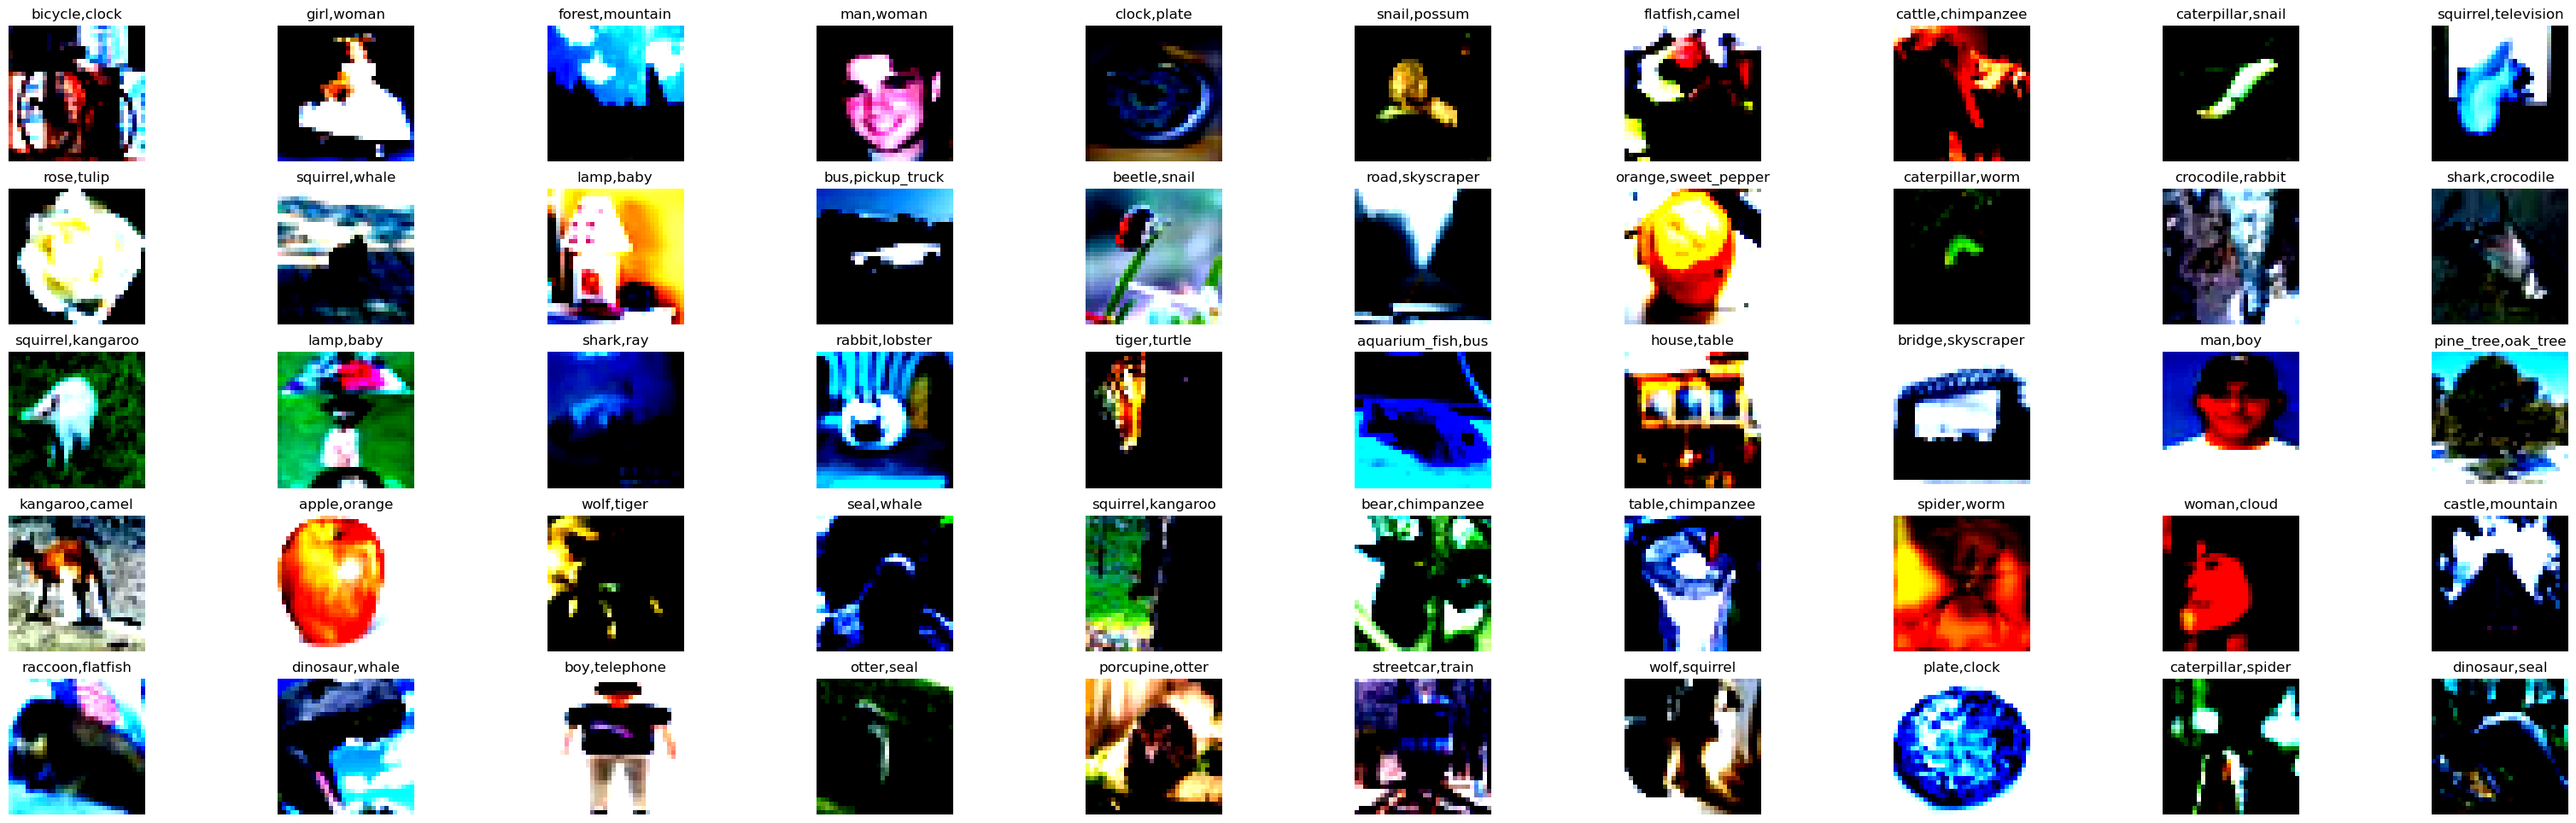

test accuracy tensor(0.5468, device='cuda:0')


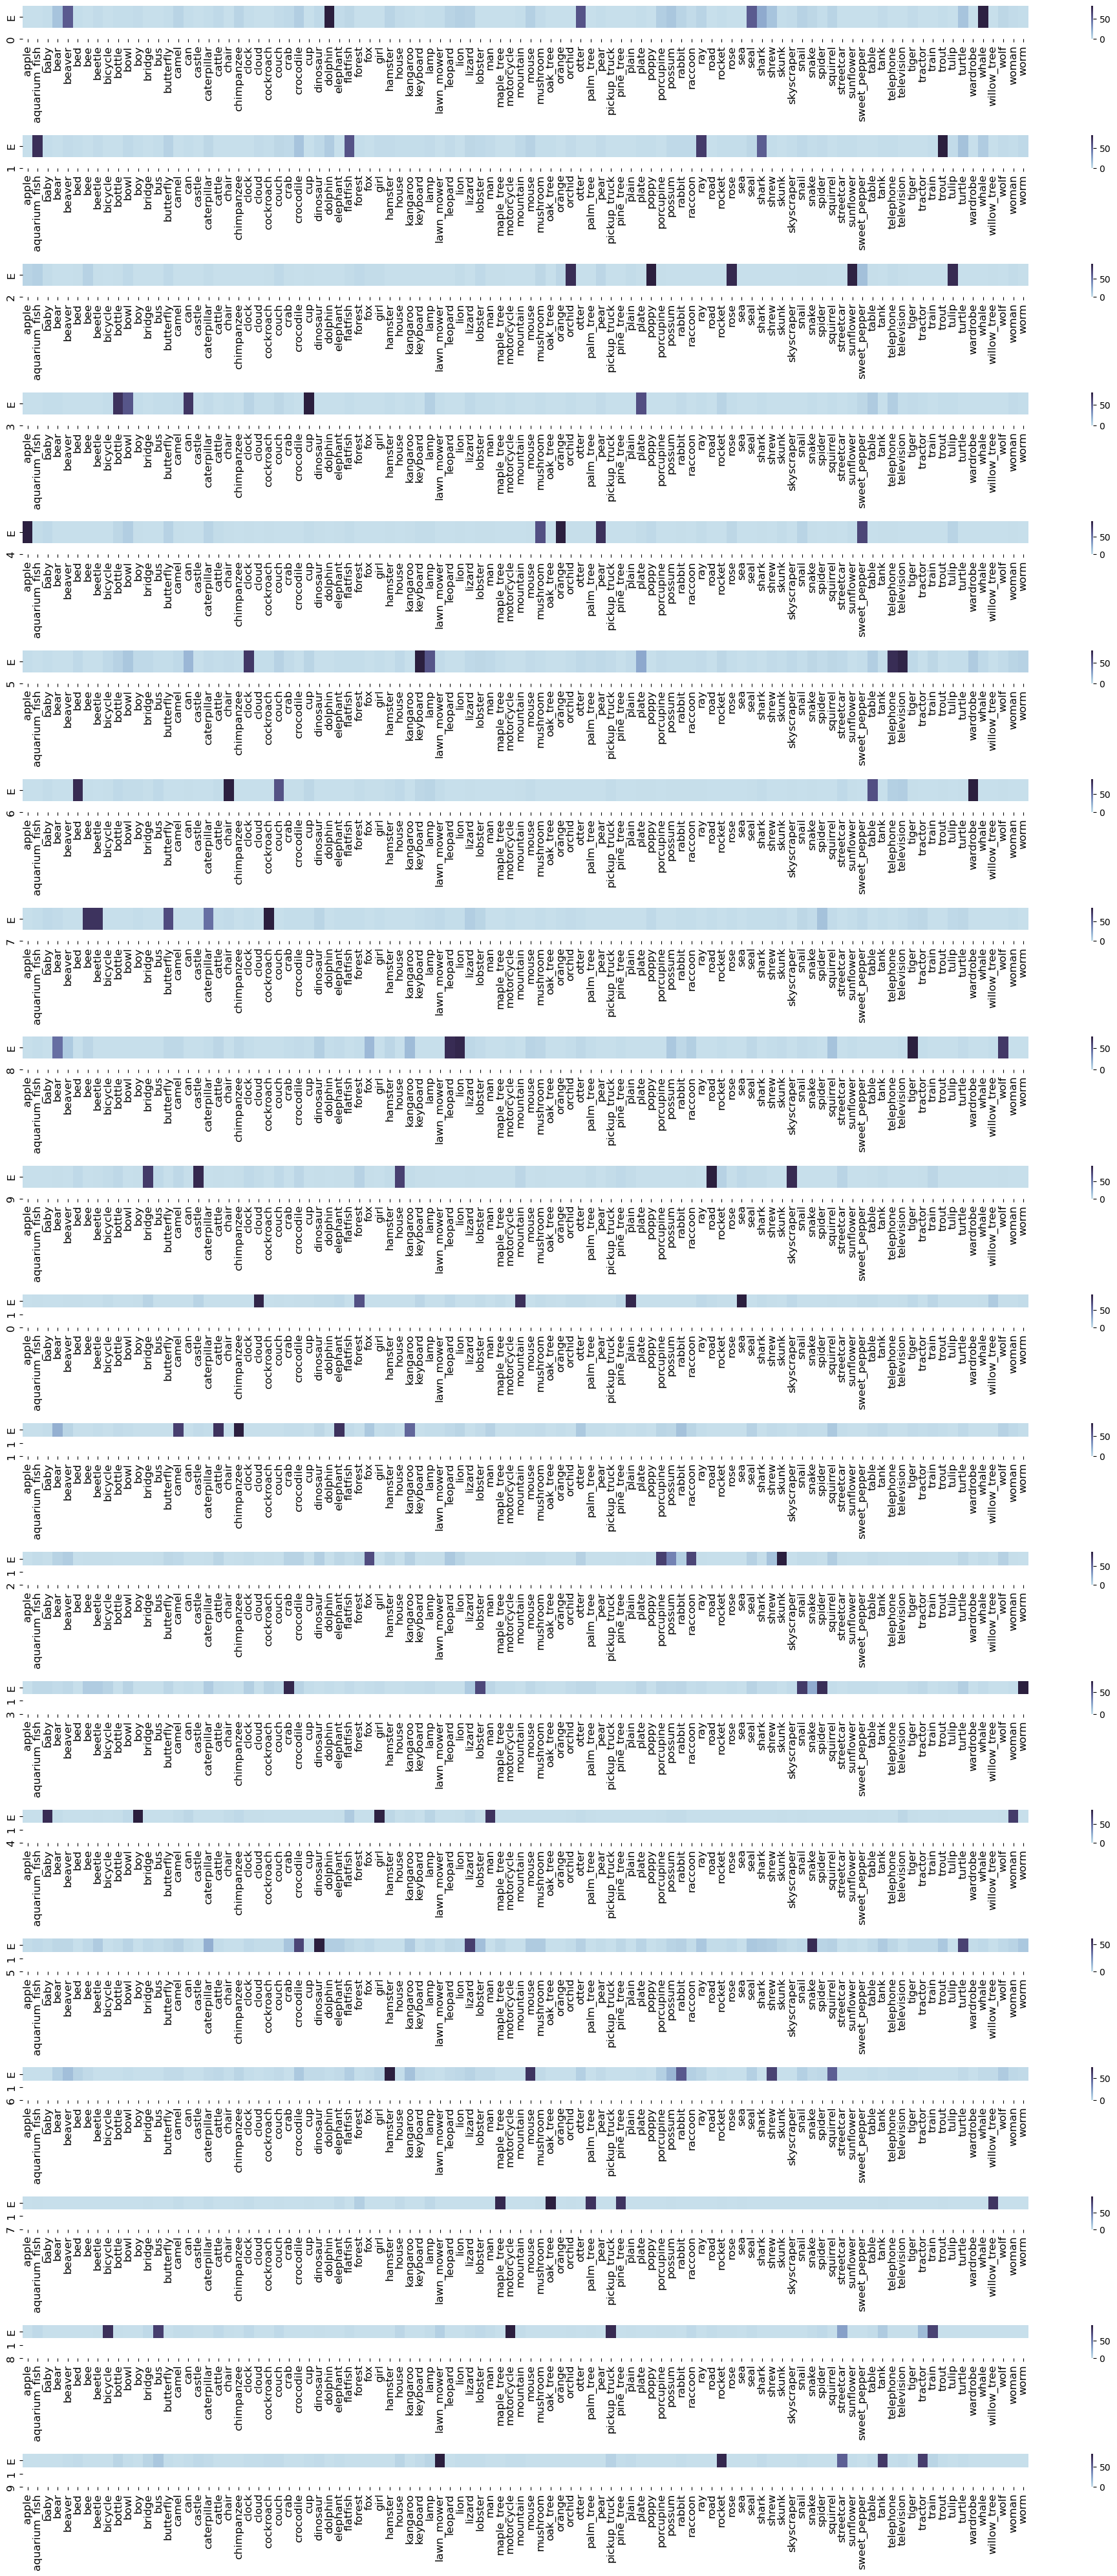

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_4 = 'cifar100_pretrained_gate_prechosen_best'

m = model_4
total_experts = 20
plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
models_prechosen = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
# print(len(models_prechosen), models_prechosen)
print('Model:', plot_file)

for model in models_prechosen:
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        test_accuracy = 0
        num_batches = 0
        first_batch = True
        for images, labels in cifar100_testloader:
            
            images, labels = images.to(device), labels.to(device)
            moe_model = e_val['experts'][total_experts]['model']

            pred = moe_model(images)
            pred_labels = torch.argmax(pred, dim=1)

            expert_outputs = moe_model.expert_outputs
            gate_outputs = moe_model.gate_outputs
            # print('gate outputs', gate_outputs.shape)

            pred_gate_labels = torch.argmax(gate_outputs, dim=1).to(device)
            
            if first_batch:
                incorrect = torch.where((labels == pred_labels) == False)[0]
                print('Number incorrect', len(incorrect))
                expected = [class_expert_map[l.item()] for l in labels[incorrect]]
                actual = [class_expert_map[l.item()] for l in pred_labels[incorrect]]
                misclassified_by_expert = []
                index = 0
                for i,j in zip(expected,actual):
                    if i==j:
                        misclassified_by_expert.append(index)
                    index += 0
                print('Number misclassified by expert', len(misclassified_by_expert))
                print('Number misclassified by gate', len(incorrect)-len(misclassified_by_expert))
                gate_outputs_for_expected = gate_outputs[range(len(expected)), expected]
                gate_outputs_for_actual = gate_outputs[range(len(actual)), actual]
                for ep,e,ec,ap,a,ac in zip(gate_outputs_for_expected,expected,np.asarray(classes_cifar100)[labels.cpu()[incorrect]],
                                                  gate_outputs_for_actual, actual, np.asarray(classes_cifar100)[pred_labels.cpu()[incorrect]]):
                    print(ep.item(),e,ec,ap.item(),a,ac)
                    
                first_batch = False
                num_images = 50
                incorrect_images = images[incorrect] 
                images_to_plot = incorrect_images[0:num_images]
                selected_labels_expected = labels[incorrect][0:num_images]
                selected_labels_actual = pred_labels[incorrect][0:num_images]
                selected_labels = [classes_cifar100[i]+','+classes_cifar100[j] for i,j in zip(selected_labels_expected,selected_labels_actual)]
                images_to_plot = torch.transpose(images_to_plot,0,1)
                new_shape = images_to_plot.shape
                print(new_shape)
                # images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
                images_to_plot = images_to_plot.permute(1,2,3,0)
                plot_colour_images(images_to_plot.cpu(), nrows=int(num_images/10), ncols=10,thefigsize=(40,12), titles=selected_labels,filename='incorrect_images')
                
            for label, expert in zip(labels, pred_gate_labels):
                class_expert_table[expert,label] += 1
            
            test_accuracy += accuracy(pred, labels)
            num_batches += 1
        
        print('test accuracy', test_accuracy/num_batches)
        
        fig1,ax1 = plt.subplots(total_experts, 1, sharex=False, sharey=False, figsize=(20,40))
        
        for i in range(total_experts):
            sns.heatmap(class_expert_table[i,:].reshape(1,-1), xticklabels=classes_cifar100, yticklabels='E'+str(i), cmap=cmap, fmt='d', annot_kws={"size": 14}, ax=ax1[i])
            ax1[i].set_xticklabels(ax1[i].get_xticklabels(), fontsize=12, rotation=90)
            ax1[i].set_yticklabels(ax1[i].get_yticklabels(), fontsize=12)
        plt.tight_layout()
        image_file = generate_plot_file(m, specific='class_expert_table_'+str(i)+'_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
        plt.savefig(os.path.join(fig_path, image_file))
        plt.show()

Min Training Error 0.174
Mutual Information 4.322
Sample Entropy 0.469
Expert Usage 4.322
cifar100_pretrained_gate_prechosen_100_20_models.pt


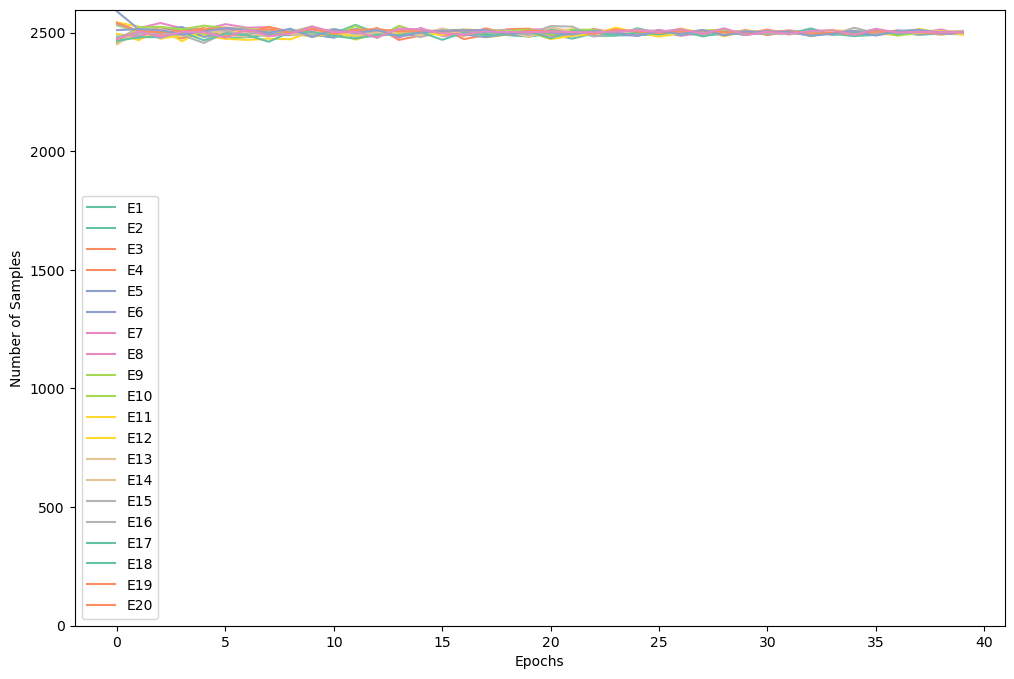

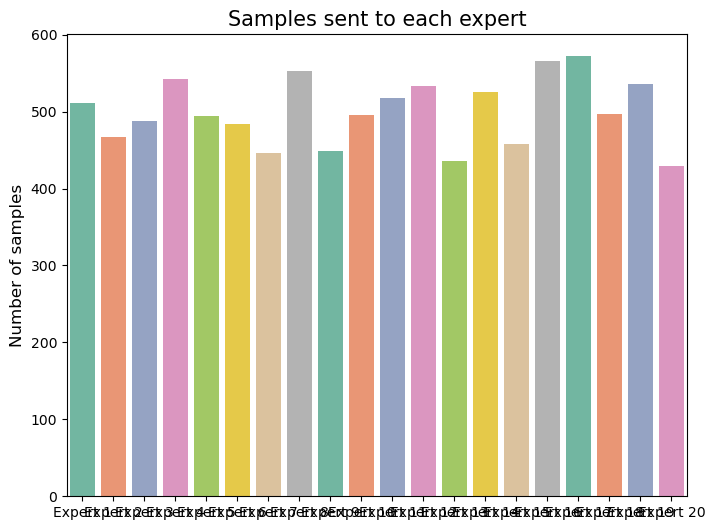

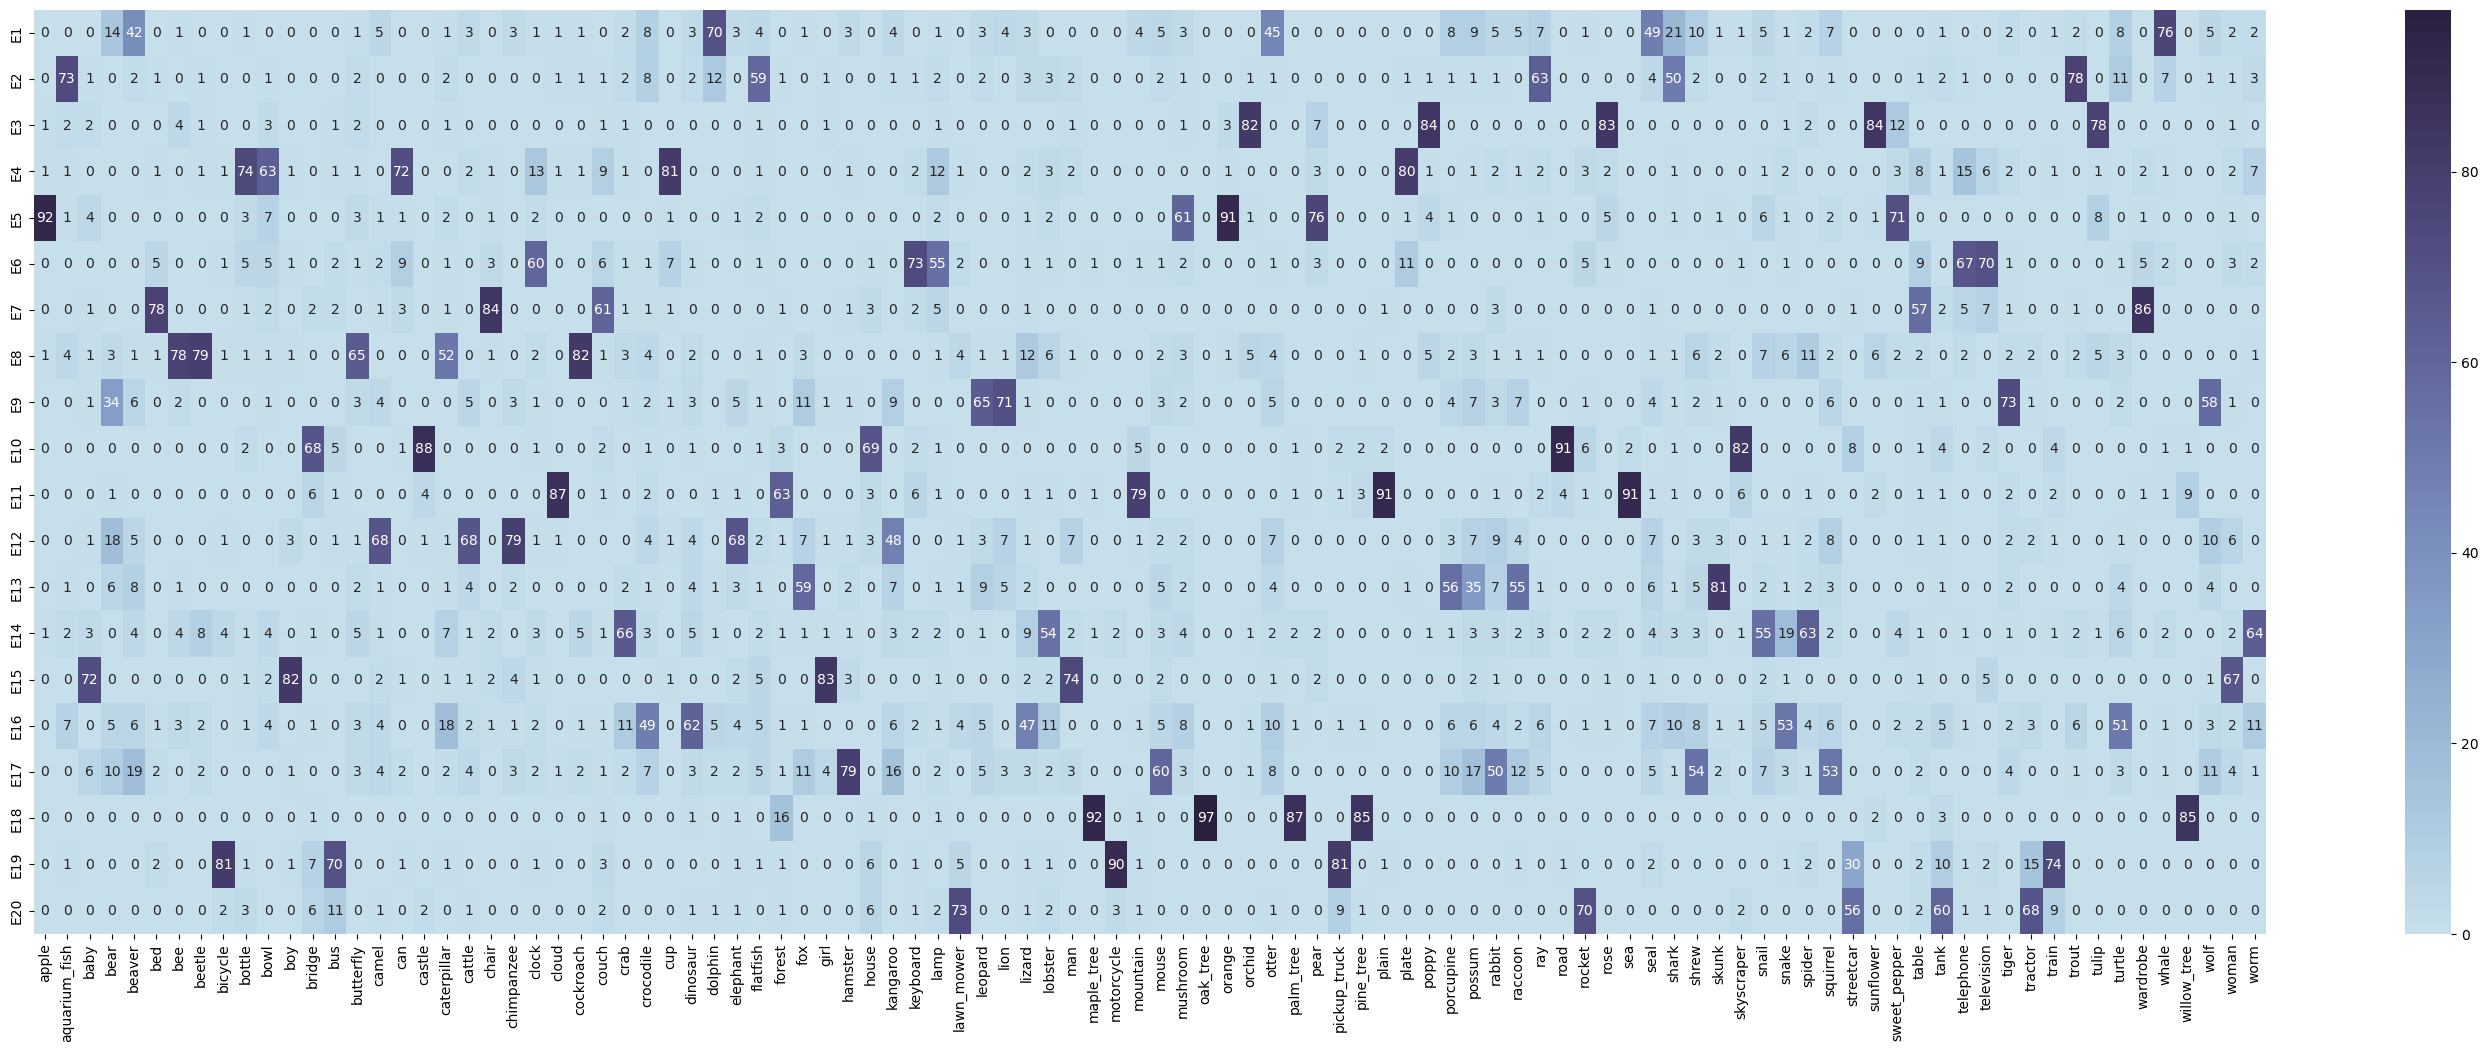


Experts used by the gate for classification of each digit


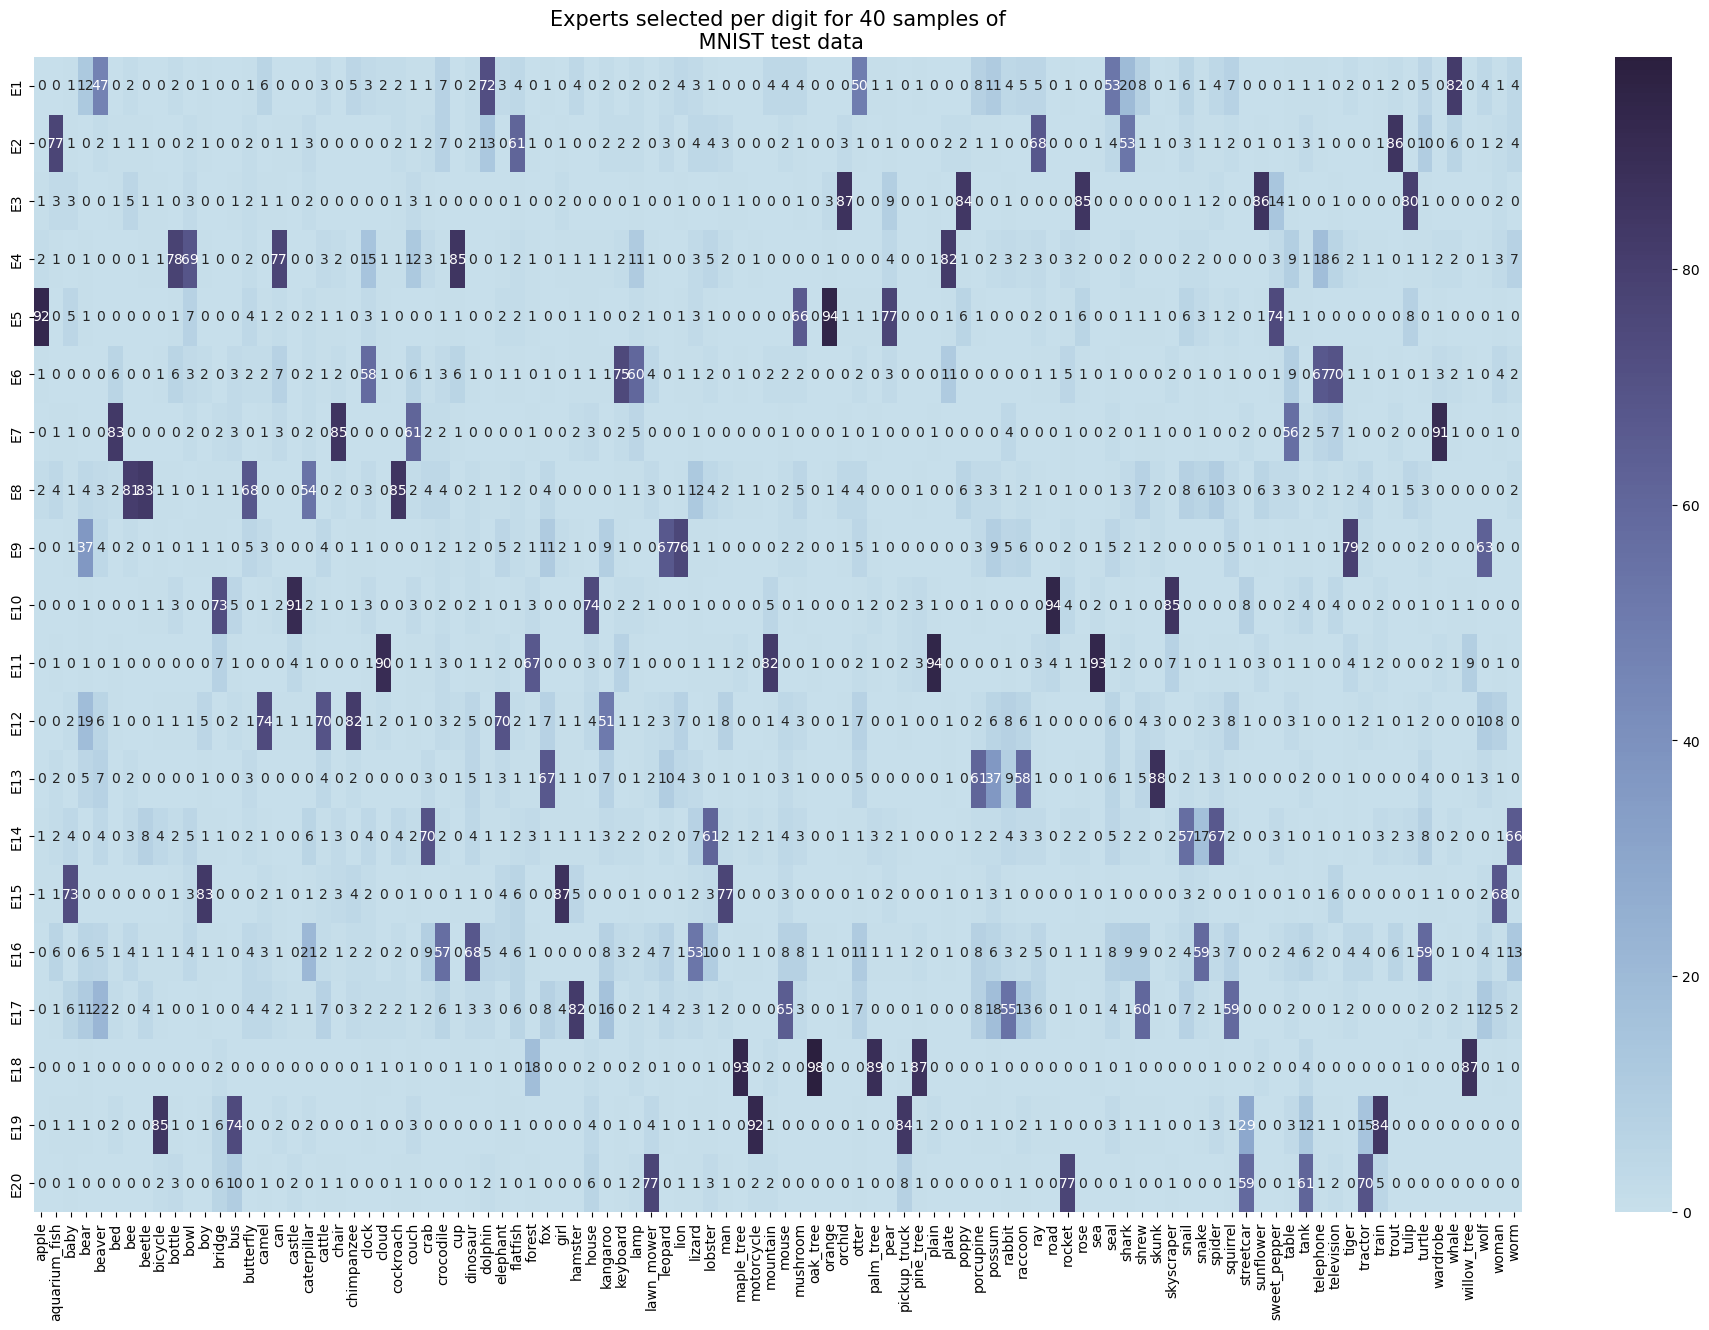

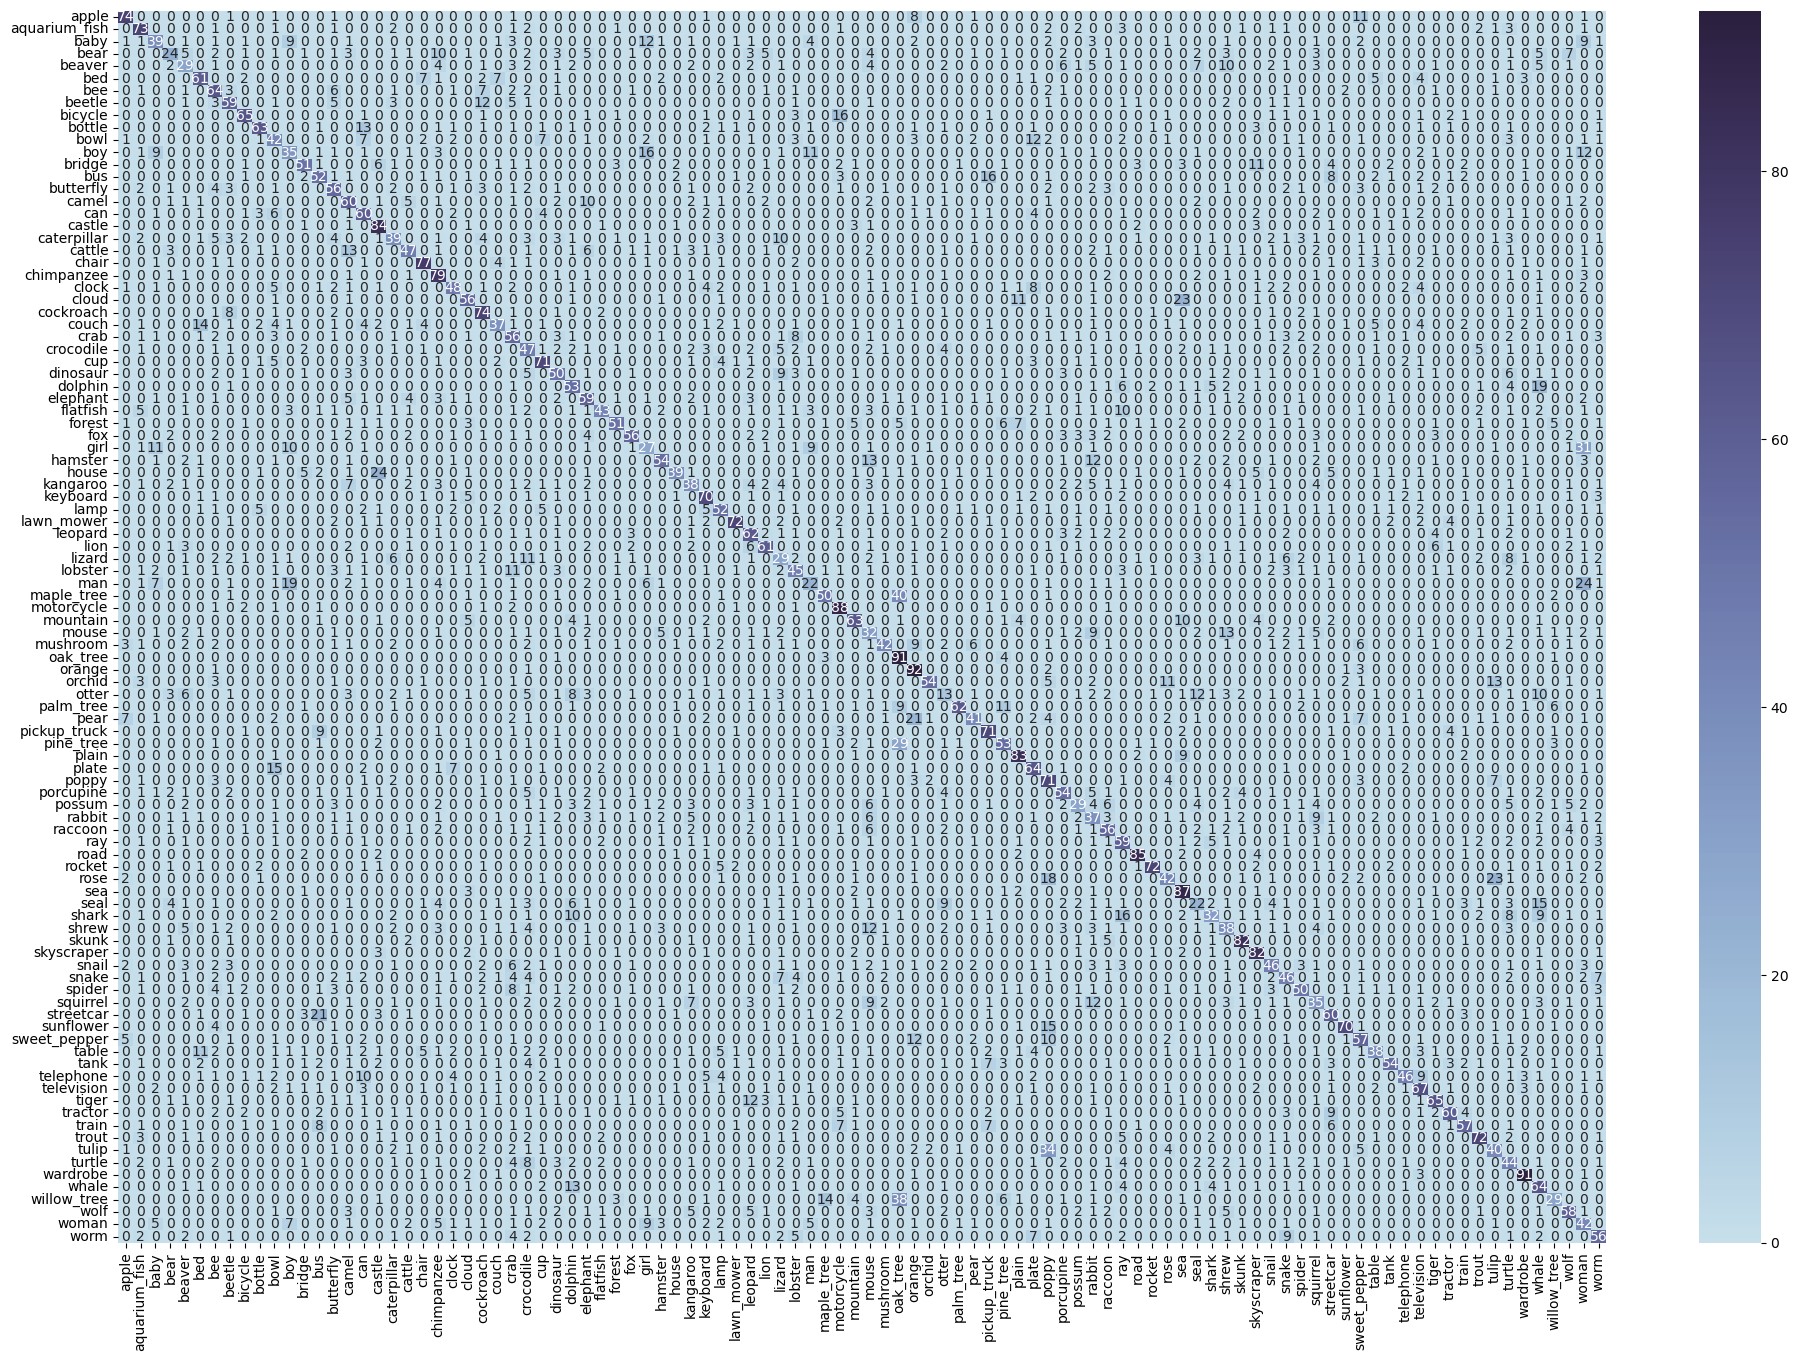

In [24]:
m = 'cifar100_pretrained_gate_prechosen'

total_experts = 20
num_classes = 100
classes = classes_cifar100
num_epochs = 40
temps=[[1]*num_epochs]
test_loader = cifar100_testloader

w_importance_range = [0.0]

plot_expert_usage(m, test_loader, temps=temps,
                 w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path, device=device)